In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import feather
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm, metrics
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = feather.read_dataframe('Datasets/5clusters.feather')
num_cols = ['trip_distance', 'trip_duration', 'fare_amount', 'tolls_amount']
cat_cols = ['cluster', 'hour']
df['tip_level'] = df['tip_level'].apply(int)

X = df[num_cols+cat_cols]

oh = pd.DataFrame()
for c in cat_cols:
    dummies = pd.get_dummies(X[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

X = pd.concat([X[num_cols], oh], axis=1)
y = df['tip_level']

In [6]:
X.head(2)

,trip_distance,trip_duration,fare_amount,tolls_amount,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,hour_6,...,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17
0,1.3,10.716667,8.5,0.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1.1,8.883333,7.5,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 30034)

In [8]:
def print_accs(model, X_train, y_train, X_test, y_test):
    # Training accuracy
    y_pred_train = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, y_pred_train)
    print("Training Accuracy: {:.5f}".format(train_acc))

    # Testing accuracy
    y_pred_test=model.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, y_pred_test)
    print("Testing Accuracy: {:.5f}".format(test_acc))
    print("")
    return(train_acc, test_acc)

# Preliminary models

### K-nearest neighbour

In [5]:
from sklearn.neighbors import KNeighborsClassifier

for k in [5,7,9,11,13]:
    print(f"{k} Nearest Neighbours")
    nn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    accs = print_accs(nn, X_train, y_train, X_test, y_test)

5 Nearest Neighbours
Training Accuracy: 0.78354
Testing Accuracy: 0.71293

7 Nearest Neighbours
Training Accuracy: 0.77317
Testing Accuracy: 0.72979

9 Nearest Neighbours
Training Accuracy: 0.76770
Testing Accuracy: 0.73867

11 Nearest Neighbours
Training Accuracy: 0.76538
Testing Accuracy: 0.74477

13 Nearest Neighbours
Training Accuracy: 0.76387
Testing Accuracy: 0.74801



### Linear SVM model

In [6]:
for c in [0.001, 0.01, 0.1, 1.0, 5]:
    svm_model = svm.LinearSVC(C=c).fit(X_train, y_train)
    print("C =", c)
    print_accs(svm_model, X_train, y_train, X_test, y_test)

C = 0.001
Training Accuracy: 0.70379
Testing Accuracy: 0.70323


C = 0.01
Training Accuracy: 0.70560
Testing Accuracy: 0.70487


C = 0.1
Training Accuracy: 0.70923
Testing Accuracy: 0.70861


C = 1.0
Training Accuracy: 0.68084
Testing Accuracy: 0.67963


C = 5
Training Accuracy: 0.50638
Testing Accuracy: 0.50414




### (One-vs-all) Logistic regression

In [11]:
lgr_model = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
print_accs(lgr_model, X_train, y_train, X_test, y_test)

Training Accuracy: 0.71719
Testing Accuracy: 0.71558



(0.7171881867547604, 0.715584526062823)

### Neural network

In [15]:
# Get labels one hot encoded
n = len(df)
labels = df['tip_level']
y = np.zeros((n, 3))
for i in range(n):
    y[i, labels[i]-1] = 1
    
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30034)

**Find max accuracy based on number of nodes** <br>
This initial neural network contains a single hidden layer with a sigmoid activation function with 10 nodes. The next layer which is the output uses a softmax activation function essentially gives probabilities for each possible output. The actual output is determined by the one with the highest probability.  
For backpropagation, I used a cross-entropy loss function to optimise the weights as it is the popular choice for a softmax activation in the output layer. The forward and backpropagations was done through a total of 25 epochs. 

In [58]:
# Try different number of nodes in the hidden layer
models = []
ns = list(range(4,21,2))
for n in ns:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n, activation=tf.nn.sigmoid,input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])
    models.append(model)

In [59]:
# Train the model
train_accs = []
test_accs = []
for model in models:
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    train_accs.append(model.evaluate(X_train, y_train, verbose=0)[1])
    test_accs.append(model.evaluate(X_test, y_test, verbose=0)[1])

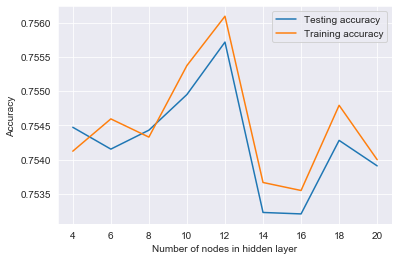

In [31]:
# Plot the train and test accuracy against number of nodes
sns.set_style("darkgrid")
plt.plot(ns, test_accs, label="Testing accuracy")
plt.plot(ns, train_accs, label="Training accuracy");
plt.legend(loc="upper right")
plt.xlabel("Number of nodes in hidden layer")
plt.ylabel("Accuracy")
plt.xticks(np.arange(min(ns), max(ns)+1, 2))
plt.show()

# Refining the neural network model
Based on those preliminary models, I choose to explore the neural network model deeper and refine it. <br>

### Target variable encoding
Cheng's paper (2007): https://arxiv.org/abs/0704.1028
<br><br>
Drawing from the paper by Cheng et al. (2007) paper on ordinal regression using neural network, I tried a different approach at encoding the tip level that is fed into the neural network. Instead of a simple one-hot encoding method where 1 would be encoded as [1,0,0], 2 as [0,1,0] and 3 as [0,0,1], I tried encoding it as [1,0,0], [1,1,0] and [1,1,1] respectively.
<br><br>
This method uses only a single hidden layer with a sigmoid activation function to a number of nodes equal to the number of classes. The loss function is also changed to binary cross entropy. The target function also means that the loss is smaller the closer the prediction is to the right class.  The class label k is given as the first index of the output where its value is less than 0.5.



In [43]:
df = feather.read_dataframe('Datasets/5clusters.feather')
df['tip_level'] = df['tip_level'].apply(int)
num_cols = ['trip_distance', 'trip_duration', 'fare_amount', 'tolls_amount']
cat_cols = ['cluster', 'hour']

X = df[num_cols+cat_cols]

oh = pd.DataFrame()
for c in cat_cols:
    dummies = pd.get_dummies(X[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

X = pd.concat([X[num_cols], oh], axis=1)

In [60]:
def get_row(n):
    row = [0,0,0]
    for i in range(n):
        row[i]=1
    return row

# new encoding ([1,0,0], [1,1,0], [1,1,1])
y = []
for i in range(len(X)):
    y.append(get_row(df['tip_level'][i]))
y = np.array(y)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=30034)

In [54]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, activation=tf.nn.sigmoid,input_shape=(X_train.shape[1],)))

# Compile and print out summary of model
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 3)                 66        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Train the model
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

In [56]:
# Testing the model 
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTrain accuracy: {train_acc}\nTest accuracy: {test_acc}')

94042/94042 [==============================] - 2s 19us/sample - loss: 0.2603 - acc: 0.9009

Train accuracy: 0.900935709476471
Test accuracy: 0.9008629322052002
